A quick beginner's guide to coding the fundamental algorithms in ML has been on my todo-list for a while. Heavily inspired by [Napkin ML](https://github.com/eriklindernoren/NapkinML)

### Table of Contents

- [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Linear Regression](#Linear-Regression)
- [Logistic Regression](#Logistic-Regression)

More coming soon!

This post hides some of the boilerplate code: if you want to extend these tutorials or play around with them, check them out [here](https://github.com/dibyaghosh/ml_tidbits/blob/master/QuickML/QuickML.ipynb)


### The Basic Imports

A machine learner never leaves home without NumPy

*Warning*: If you don't know NumPy, then this article may be difficult to comprehend. The [Scipy Lectures](http://www.scipy-lectures.org/) are a good resource.

In [2]:
import numpy as np

### Introducing our Dataset

We'll use a simple 2 dimensional nonlinear dataset to run our algorithms, so that it's easier to visualize, yet complex enough that we see different types of behaviour from different algorithms. 

In [17]:
# See Github for the full code - hidden for brevity
Xs = ...
Ys = ...
test_Xs = ...
test_Ys = ...

def accuracy(model,X,Y):
    pass 
def plot(model,X,Y):
    pass


For each algorithm, we'll train it on a dataset with 1000 samples, and plot the decision curve learned by the algorithm. For example, here's the "optimal" classifier. The color of the point is the true class, and the color of the background is what the classifier predicts.

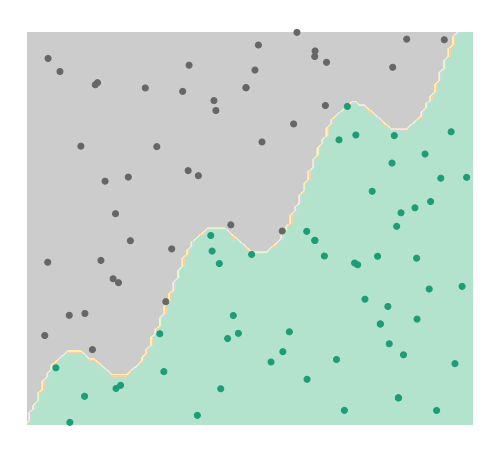

In [5]:
# HIDDEN
import matplotlib.pyplot as plt
%matplotlib inline

Xs = np.random.rand(1000,2)*10
Ys = np.array([x[1] > x[0]+np.sin(x[0]*2) for x in Xs])

test_Xs = np.random.rand(1000,2)*10
test_Ys = np.array([x[1] > x[0]+np.sin(x[0]*2) for x in test_Xs])

def accuracy(model,X,Y):
    return np.count_nonzero([model.predict(x)==y for (x,y) in zip(X,Y)])/len(X)

def plot(model,X,Y,shades=False,nPoints=100,**kwargs):
    plt.figure(figsize=(8,8))
    h = 100
    x_min, y_min = np.min(X,axis=0)
    x_max, y_max = np.max(X,axis=0)
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, h),
                         np.linspace(y_min, y_max, h))

    # here "model" is your model's prediction (classification) function
    Z = np.array([model.predict(x) for x in np.c_[xx.ravel(), yy.ravel()]])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel2,**kwargs)
    subpoints = np.random.choice(len(X),nPoints)
    plt.scatter(X[subpoints, 0], X[subpoints, 1], c=Y[subpoints], cmap=plt.cm.Dark2)
    plt.axis('off')

    # Plot also the training points
class Dummy:
    def predict(x):
        return x[1] > x[0]+np.sin(x[0]*2)
plot(Dummy,Xs,Ys)

## K-Nearest Neighbors

$k$-Nearest Neighbors is a non-parametric machine learning model that predicts classes for points x based on the k closest values to x seen in the training set. 

In [7]:
from collections import Counter

class kNN:
    def __init__(self,k=1):
        self.k = k
  
    def fit(self,xs,ys,k=1):
        """
        Since kNN is nonparametric, we need to keep the training data around during test time.
        k-NN doesn't do any additional preprocessing
        """
        self.xs = xs 
        self.ys = ys
  
    def predict(self,x):
        # Sort training points by distance to the new point
        closest_points = np.argsort(np.linalg.norm(self.xs-x,axis=1))[:self.k]
        # Get labels of these close points
        closest_labels = self.ys[closest_points] 
        # Return the most common label
        return Counter(closest_labels).most_common(1)[0][0] 

Accuracy is  0.978


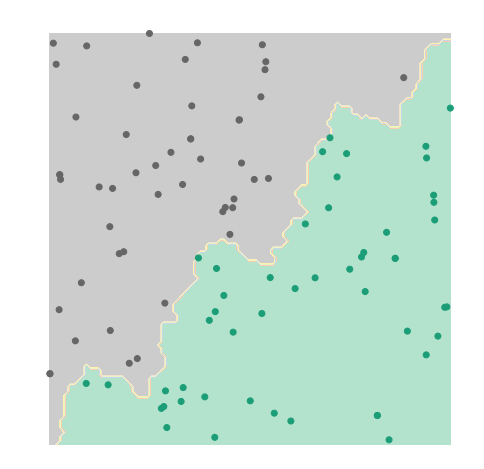

In [8]:
# HIDDEN
kNN_classifier = kNN(1)
kNN_classifier.fit(Xs,Ys)
plot(kNN_classifier,test_Xs,test_Ys)
print("Accuracy is ",accuracy(kNN_classifier,test_Xs,test_Ys))


## Linear Regression

Linear regression attempts to find the best *linear* model $f(x) =w^Tx$ to fit the data. The training procedure revolves around solving the following equation
$$w^* = \arg\min_{w \in \mathbb{R}^d} \sum_{i=1}^n (w^TX_i - y_i)^2 $$

We can write this in matrix form, where $X$ is a $n \times d$ matrix where each row corresponds to a training point. 
$$w^* = \arg\min_{w \in \mathbb{R}^d} \|Xw-y\|_2^2$$

Using matrix calculus, we have that  $\nabla_w = X^T(Xw-y)$, so the optimal solution $w^*$ satisfies

$$(X^TX)w^* = X^Ty$$

In [10]:
class LinReg:
    def fit(self,xs,ys):
        """
        Solving (X^TX)w^* = X^Ty
        """
        
        self.w = np.linalg.solve(xs.T.dot(xs),xs.T.dot(ys))
  
    def predict(self,x):
        return self.w.dot(x) > 0.5 # If predict >0.5, then say class 1, else class 0

Accuracy is  0.856


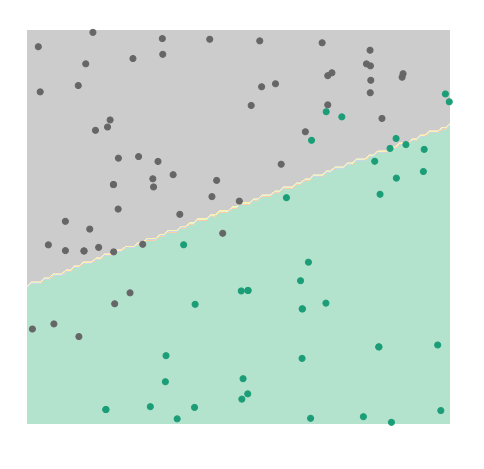

In [11]:
# HIDDEN

linear_classifier = LinReg()
linear_classifier.fit(Xs,Ys)
print("Accuracy is ",accuracy(linear_classifier,test_Xs,test_Ys))
plot(linear_classifier,test_Xs,test_Ys)

## Logistic Regression

Logistic regression is similar to linear regression, but specializes to *classification* tasks by predicting probabilities $p(y_i=1~\mid~x_i)$. 

If we naively apply linear regression to predicting probabilities, we'll be maximizing $p(y=1|x) = w^Tx$. However, since $w^Tx$ can be between $(-\infty, \infty)$, it matches poorly to the desired output $(0,1)$. 

Estimating the *odds* $\cfrac{p(y=1~\mid~x)}{p(y=0~\mid~x)}$ as a linear function is better, but still attains values only in $[0,\infty)$. To truly exploit the full range of values that a linear function affords, we predict the **log-odds** as a linear function of $x$.

$$\text{Log-odds} = \log \frac{P(y=1|x)}{P(y=0|x)} = w^Tx$$


Solving this out for the probabilities, we see that the probability is given by the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) 
$$P(Y=1|x) = \cfrac{e^{w^Tx}}{1+e^{w^Tx}} = \frac{1}{1+e^{-w^Tx}}$$


We now have a model which predicts probabilities:

$$
\begin{align*}
P(Y=y ~~\vert~~X=x,w) &= \begin{cases} p & y=1 \\ 1-p & y=0 \end{cases}\\~\\
&=p^y(1-p)^{1-y}
\end{align*}
$$


Now, how do we find the so-called "best" probabilities? The standard method to do so is **Maximum Likelihood Estimation** (MLE), which maximizes the probability of the training data under our model. Intuitively, we would like to find the model which was most likely to generate the data in the first place.

In the following calculations, we'll use the abbreviation $p_i = \cfrac{e^{w^Tx_i}}{1+e^{w^Tx_i}}$ (our predicted probability for $y_i=1$ under $x_i$)


\begin{align*}
w^* &= \arg \max_{w} \prod_{i=1}^n P(Y=y_i|X=x_i,w)\\
& \stackrel{(a)}{=} \arg \max_{w} \sum_{i=1}^n \log P(Y=y_i|X=x_i,w)\\
%&= \arg \max_{w} \prod_{i=1}^n \left(\frac{p_i}{1-p_i}\right)^{y_i}(1-p_i)\\
&= \arg \max_{w} \sum_{i=1}^n y_i \log \frac{p_i}{1-p_i} + \log 1-p_i \\
&= \arg \max_{w} \sum_{i=1}^n y_i w^Tx - \log 1+e^{w^Tx} \\
\end{align*}


Unlike linear regression above, this has no closed-form solution. To solve, instead we have two methods: gradient descent and convex optimization

### Gradient Ascent

The gradient of the objective is given by

$$\nabla_w = \sum_{i=1}^n y_i x - p_i x = \sum_{i=1}^n (y_i-p_i)x$$

In [13]:
class LogRegGD:
    def __init__(self,a=.001,nIter=1000):
        self.a = a # Learning Rate
        self.nIter = nIter # Number of gradient update
        
    def probabilities(self,xs):
        return 1/(1+np.exp(-1*xs.dot(self.w)))
    
    def fit(self,xs,ys):
        """
        Take gradient steps
        """
        xs = np.hstack([xs,np.ones((len(xs),1))]) # Add bias term
        self.w = np.random.rand(xs.shape[1])
        for i in range(self.nIter):
            ps = self.probabilities(xs)
            self.w += self.a*(ys-ps).dot(xs) # Take Gradient Descent term
        
  
    def predict(self,x):
        x = np.concatenate((x,[1])) # Add bias term
        return self.w.dot(x) > 0 # If w^Tx > 0, then p > .5


Accuracy is  0.941


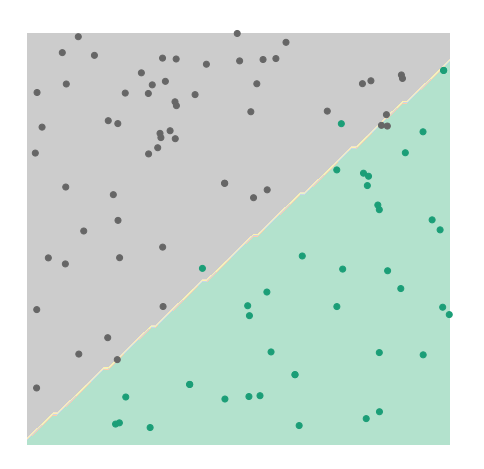

In [14]:
# HIDDEN

logistic_classifier = LogRegGD()
logistic_classifier.fit(Xs,Ys)
print("Accuracy is ",accuracy(logistic_classifier,test_Xs,test_Ys))
plot(logistic_classifier,test_Xs,test_Ys)

### Convex Formulation

The objective function is convex; we can use a convex optimization library to solve. We'll use `cvxpy` (install guide [here](http://www.cvxpy.org/en/latest/install/index.html)). This involves extra libraries, but has a significant advantage over the gradient descent objective in that it returns the exact solution, without worrying about hyperparameters and divergence concerns.

Recall from above that the objective is given by 

$$\arg \max_{w} \sum_{i=1}^n y_i w^Tx - \log 1+e^{w^Tx}$$

We can write this in matrix notation as 

$$y^TXw - \mathbf{1}^T\text{Logistic}(Xw)$$

Where $\mathbf{1}$ is the ones-vector in $\mathbb{R}^n$, and $\text{Logistic}(\cdot)$ applies the logistic function $f(x) = \log 1 + e^x$ to each entry

In [15]:
import cvxpy as cvx

class LogRegCVX:
    def fit(self,xs,ys):
        # Adding a bias term
        xs = np.hstack([xs,np.ones((len(xs),1))])
        
        # Formulating the objective
        w = cvx.Variable(xs.shape[1])
        objective = -1*(ys.dot(xs)*w-cvx.sum_entries(cvx.logistic(xs*w)))
        
        # Solving and storing the optimal value
        cvx.Problem(cvx.Minimize(objective)).solve()
        self.w = np.array(w.value).flatten()
          
    def predict(self,x):
        x = np.concatenate((x,[1])) # Add bias term
        return self.w.dot(x) > 0 # If w^Tx > 0, then p > .5


Accuracy is  0.935


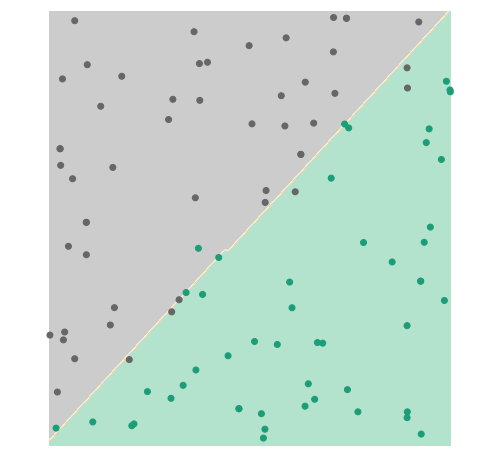

In [16]:
# HIDDEN 
cvx_logistic_classifier = LogRegCVX()
cvx_logistic_classifier.fit(Xs,Ys)
print("Accuracy is ",accuracy(cvx_logistic_classifier,test_Xs,test_Ys))
plot(cvx_logistic_classifier,test_Xs,test_Ys)

<!--
### Kernelized Linear Regression

An interesting property of linear regression is that the optimal vector can be written in terms of the dot products between all the training data $x_i \cdot x_j$. **Kernelized linear regression** uses this fact to find models where

$$f(x) = w^Tg(x)$$

where $g(x)$ is some prespecified "latent" representation. This can allow us to solve more complicated problems via the same linear regression framework. For example, say we wanted to find the best quadratic function $y=f(x_1,x_2)$,

$$f(x_1,x_2) = a_1x_1^2 + a_2x_2^2 + a_3x_1x_2 + a_4x_1 + a_5x_2 + a_6$$

Although we can solve this using traditional tools like gradient descent, a simpler method is to write 
$$g(x_1,x_2) = \begin{bmatrix}x_1^2\\x_2^2\\x_1x_2\\x_1\\x_2\\1\end{bmatrix}~~~~~~~~~~~~~~~~~f(x_1,x_2) = w^Tg(x_1,x_2)$$

Now, we've reduced it into a linear regression problem with $X'$ and $y$ (where $X'$ simply contains these latent representations).There are two approaches at this point:

#### Primal Form

The primal form is as straightforward as simply solving the linear system with $X'$ and $y$. This works fine for our toy case, although notice that our problem is more difficult (relatively) because now we are optimizing in $\mathbb{R}^6$ instead of $\mathbb{R}^2$. If the function $g(x)$ had been more high-dimensional (say 1000 dimensions or more), this formulation quickly looses success.

#### Dual Form

If we examine the exact least-squares objective with this new matrix $X'$, some interesting structure appears. For the moment, let's consider $g(x) ~~\mathbb{R}^d \to \mathbb{R}^{k}$ 

$$\arg\min_{w \in \mathbb{R}^{k}} \|X'w - y\|_2^2$$

The fundamental theorem of linear algebra says that for a given matrix $X \in \mathbb{R}^{n \times k}$ any vector $w \in \mathbb{R}^k$ can be decomposed into two components: 
$$w = \underbrace{w_0}_{\text{in the null space of $X$}} +  \underbrace{w_1}_{\text{in the range of $X^T$}}$$
More concretely, it means 
$$w = w_0 + X^Tz~~~~~~~~~z \in \mathbb{R}^n~~~~~~~~~Xw_0 = 0$$

For our purposes, this means that we can rewrite the optimization in terms of $w_0,z$ instead of $w$

$$\arg\min_{w_0 \in \text{Nul}(X'),z \in \mathbb{R}^n} \|X'(w_0 + X'^Tz) - y\|_2^2$$

However, because of the constraints, we can eliminate the $w_0$ term since $X'w_0 = 0$, and the problem reduces into another linear regression problem, this time with $X'X'^T = K$ the kernel matrix where $K_{ij} = X'_i \cdot X'_j$

$$\arg\min_{z \in \mathbb{R}^n} \|Kz - y\|_2^2$$

The optimal solution to this satisfies

$$K^2z = Ky$$
-->